# Stable Diffusion을 통한 잠재공간 산책

**Authors:** [Hyunwook Jo](https://github.com/ugiugi0823)<br>
**Date created:** 2024/02/11<br>
**Last modified:** 2024/02/11<br>
**Description:** Explore the latent manifold of Stable Diffusion. 

## Overview

- 생성 이미지 모델은 시각적 세계의 "잠재적 다양체"를 학습합니다.
각 점이 이미지에 매핑되는 저차원 벡터 공간입니다.
매니폴드의 해당 지점에서 다시 표시 가능한 이미지로 이동
이것을 "디코딩"이라고 합니다. Stable Diffusion 모델에서는 이를 처리합니다.
"디코더" 모델.
![The Stable Diffusion architecture](https://i.imgur.com/2uC8rYJ.png)

This latent manifold of images is continuous and interpolative, meaning that:

1. 다양체 위에서 조금만 움직여도 해당 이미지가 약간만 변경됩니다(연속성).
2. 다양체의 임의의 두 점 A와 B(즉, 임의의 두 이미지)에 대해 다음이 가능합니다.
각 중간 지점도 다양체에 있는 경로를 통해 A에서 B로 이동합니다(예:
유효한 이미지이기도 합니다). 중간점은 사이의 "보간"이라고 불립니다.
두 개의 시작 이미지.

Stable Diffusion은 단순한 이미지 모델이 아니라 자연어 모델이기도 합니다.
여기에는 두 개의 잠재 공간이 있습니다.
훈련 중에 사용되는 인코더 및 신속한 잠재 공간
이는 사전 훈련과 훈련 시간의 조합을 사용하여 학습됩니다.
미세 조정.

_Latent space walking_, or _latent space exploration_, 의 과정이다
잠재 공간에서 점을 샘플링하고 잠재 공간을 점진적으로 변경
대표. 가장 일반적인 응용 프로그램은 애니메이션을 생성하는 것입니다.
여기서 각 샘플링된 포인트는 디코더에 공급되고
최종 애니메이션의 프레임.
고품질의 잠재 표현을 위해 일관성 있는 모양을 생성합니다.
애니메이션. 이러한 애니메이션은 기능 맵에 대한 통찰력을 제공할 수 있습니다.
잠재 공간을 확보하고 궁극적으로 훈련 개선으로 이어질 수 있습니다.
프로세스. 그러한 GIF 중 하나가 아래에 표시됩니다.

![Panda to Plane](./panda2plane.gif)

이 가이드에서는 Stable Diffusion API를 활용하는 방법을 보여 드리겠습니다.
KerasCV에서 신속한 보간 및 원형 탐색을 수행합니다.
Stable Diffusion의 시각적 잠재 다양체뿐만 아니라
텍스트 인코더의 잠재 다양체.

This guide assumes the reader has a
high-level understanding of Stable Diffusion.
If you haven't already, you should start
by reading the [Stable Diffusion Tutorial](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/).

To start, we import KerasCV and load up a Stable Diffusion model using the
optimizations discussed in the tutorial
[Generate images with Stable Diffusion](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/).
Note that if you are running with a M1 Mac GPU you should not enable mixed precision.

## 준비 사항

In [1]:
import matplotlib.pyplot as plt
import torch
def plot_grid(
    images,
    path,
    grid_size,
    scale=2,
):
    fig, axs = plt.subplots(
    grid_size, grid_size, figsize=(grid_size * scale, grid_size * scale)
    )
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.margins(x=0, y=0)
    plt.axis("off")
    for ax in axs.flat:
        ax.axis("off")
    images = images.astype(int)
    for i in range(min(grid_size * grid_size, len(images))):
        ax = axs.flat[i]
        ax.imshow(images[i].astype("uint8"))
        ax.axis("off")
    for i in range(len(images), grid_size * grid_size):
        axs.flat[i].axis("off")
        axs.flat[i].remove()
    plt.savefig(
        fname=path,
        pad_inches=0,
        bbox_inches="tight",
        transparent=False,
        dpi=60,
    )
    
    
def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    if rubber_band:
        
        
        images += images[2:-1][::-1]
        
        
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )
    
    
    
def prepare_tokens(prompt, models,tokenizer, device, max_length=77):
    """
    주어진 prompt를 토큰화하고, 텐서로 변환한 후 clip 함수를 적용하는 함수입니다.

    :param prompt: 토큰화할 텍스트
    :param tokenizer: 사용할 토크나이저
    :param device: 텐서를 할당할 디바이스
    :param max_length: 최대 토큰 길이
    :return: clip 함수를 적용한 텐서
    """
    # 토큰화
    tokens = tokenizer.batch_encode_plus([prompt], padding="max_length", max_length=max_length).input_ids
    # 텐서로 변환
    tokens_tensor = torch.tensor(tokens, dtype=torch.long, device=device)
    clip = models["clip"]
    clip.to(device)
    # clip 함수 적용
    context = clip(tokens_tensor)

    return context





---

## 문제 1

## 텍스트 프롬프트 간 보간

Stable Diffusion에서는 텍스트 프롬프트가 먼저 벡터로 인코딩됩니다.
그 인코딩은 확산 과정을 안내하는 데 사용됩니다.
잠재 인코딩 벡터는 모양을 갖습니다.
77x768(매우 큽니다!), Stable Diffusion에 텍스트 프롬프트를 주면
잠재 다양체의 한 지점에서만 이미지를 생성합니다.

이 다양함을 더 자세히 살펴보기 위해 두 텍스트 인코딩 사이를 보간할 수 있습니다.
보간된 지점에서 이미지를 생성합니다.

In [10]:

import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import numpy as np
import torch

DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False


if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE

prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
uncond_prompt = "worst quality"


# 이제 함수를 사용하여 각 프롬프트에 대한 처리를 수행할 수 있습니다.
cond_context_1 = prepare_tokens(prompt_1,models, tokenizer, DEVICE)
cond_context_2 = prepare_tokens(prompt_2, models,tokenizer, DEVICE)
uncond_context = prepare_tokens(uncond_prompt,models, tokenizer, DEVICE)



interpolation_steps = 5
context_t_s = [torch.lerp(cond_context_1, cond_context_2, weight) for weight in torch.linspace(0, 1, interpolation_steps, device=DEVICE)]


## IMAGE TO IMAGE
input_image = None
# Comment to disable image to image
# image_path = "/media/hy/nwxxk/pytorch-stable-diffusion/images/dog.png"
# input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.


images = []
for i in context_t_s:
    img_tensor = pipeline.generate(
                prompt_t=i,
                uncond_prompt=uncond_context,
                input_image=input_image,
                latents_cus=None,
                strength=0.8,
                batch_size=1,
                do_cfg=True,
                art_lab=False,
                latents_custom=False,
                cfg_scale=8,
                sampler_name="ddpm",
                n_inference_steps=5,
                seed=42,
                models=models,
                device=DEVICE,
                idle_device="cpu",
                tokenizer=tokenizer)
    
    
    img_tensor = img_tensor[0]
    images.append(img_tensor)




# Combine the input image and the output image ointo a single image
export_as_gif(
"P1.gif",
[Image.fromarray(img) for img in images],
frames_per_second=2,
rubber_band=True,)


Using device: cuda


100%|██████████| 100/100 [00:08<00:00, 12.24it/s]


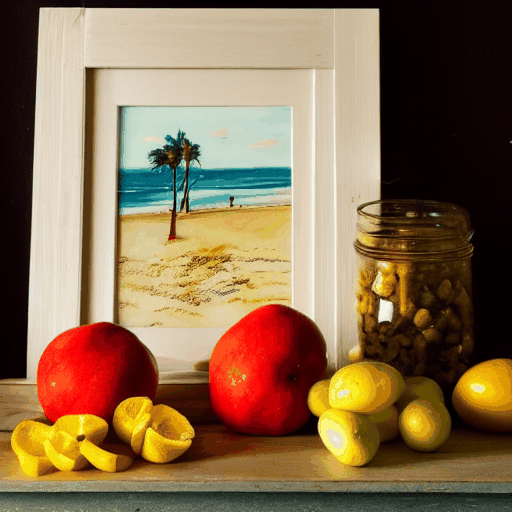

In [13]:
from PIL import Image, ImageSequence
from IPython.display import display, clear_output
import time

# GIF 파일 경로
file_path = './src/P1.gif'

# 이미지 열기
img = Image.open(file_path)

# GIF의 각 프레임을 순회하며 시각화
for frame in ImageSequence.Iterator(img):
    # Jupyter 노트북에서 이미지 출력
    clear_output(wait=True)  # 이전 출력을 지웁니다.
    display(frame)  # 현재 프레임을 출력합니다.
    time.sleep(0.1)  # 0.1초 동안 대기합니다.


결과는 놀라운 것처럼 보일 수 있습니다. 일반적으로 프롬프트 사이를 보간하면 일관되게 보이는 이미지가 생성되고 두 프롬프트의 내용 간에 점진적인 개념 전환이 나타나는 경우가 많습니다. 이는 시각적 세계의 자연스러운 구조를 밀접하게 반영하는 고품질 표현 공간을 나타냅니다.

---

## 문제 2
- 이를 가장 잘 시각화하려면 수백 단계를 사용하여 훨씬 더 세밀한 보간을 수행해야 합니다.

In [ ]:
interpolation_steps = 150
interpolated_encodings = [torch.lerp(cond_context_1, cond_context_2, weight) for weight in torch.linspace(0, 1, interpolation_steps, device=DEVICE)]
# batched_encodings = torch.chunk(torch.stack(interpolated_encodings), batches)



images = []
for i in interpolated_encodings:
    
    img_tensor = pipeline.generate(
            prompt_t=i,
            uncond_prompt=uncond_context,
            input_image=input_image,
            latents_cus=None,
            strength=0.8,
            batch_size=1,
            do_cfg=True,
            art_lab=False,
            latents_custom=False,
            cfg_scale=8,
            sampler_name="ddpm",
            n_inference_steps=50,
            seed=42,
            models=models,
            device=DEVICE,
            idle_device="cpu",
            tokenizer=tokenizer)
    
    img_tensor = img_tensor[0]
    images.append(img_tensor)
    print(len(images))

export_as_gif("P2.gif", [Image.fromarray(img) for img in images], rubber_band=True)

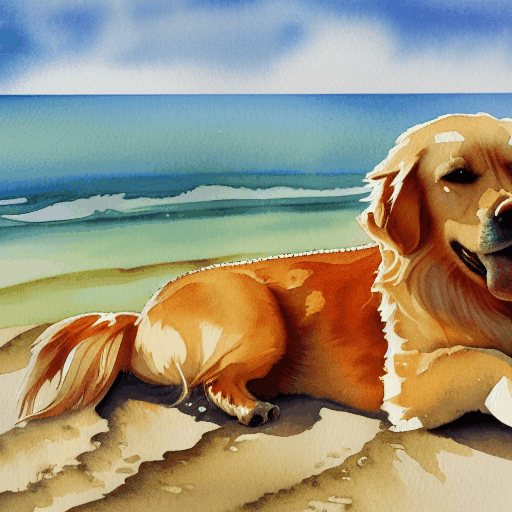

In [9]:
from PIL import Image, ImageSequence
from IPython.display import display, clear_output
import time

# GIF 파일 경로
file_path = './src/P2.gif'

# 이미지 열기
img = Image.open(file_path)

# GIF의 각 프레임을 순회하며 시각화
for frame in ImageSequence.Iterator(img):
    # Jupyter 노트북에서 이미지 출력
    clear_output(wait=True)  # 이전 출력을 지웁니다.
    display(frame)  # 현재 프레임을 출력합니다.
    time.sleep(0.1)  # 0.1초 동안 대기합니다.


---

## 문제 3
- 네 가지 프롬프트 사이를 보간할 수 있습니다.(w / noise)

100%|██████████| 50/50 [00:04<00:00, 12.23it/s]


(36, 512, 512, 3)


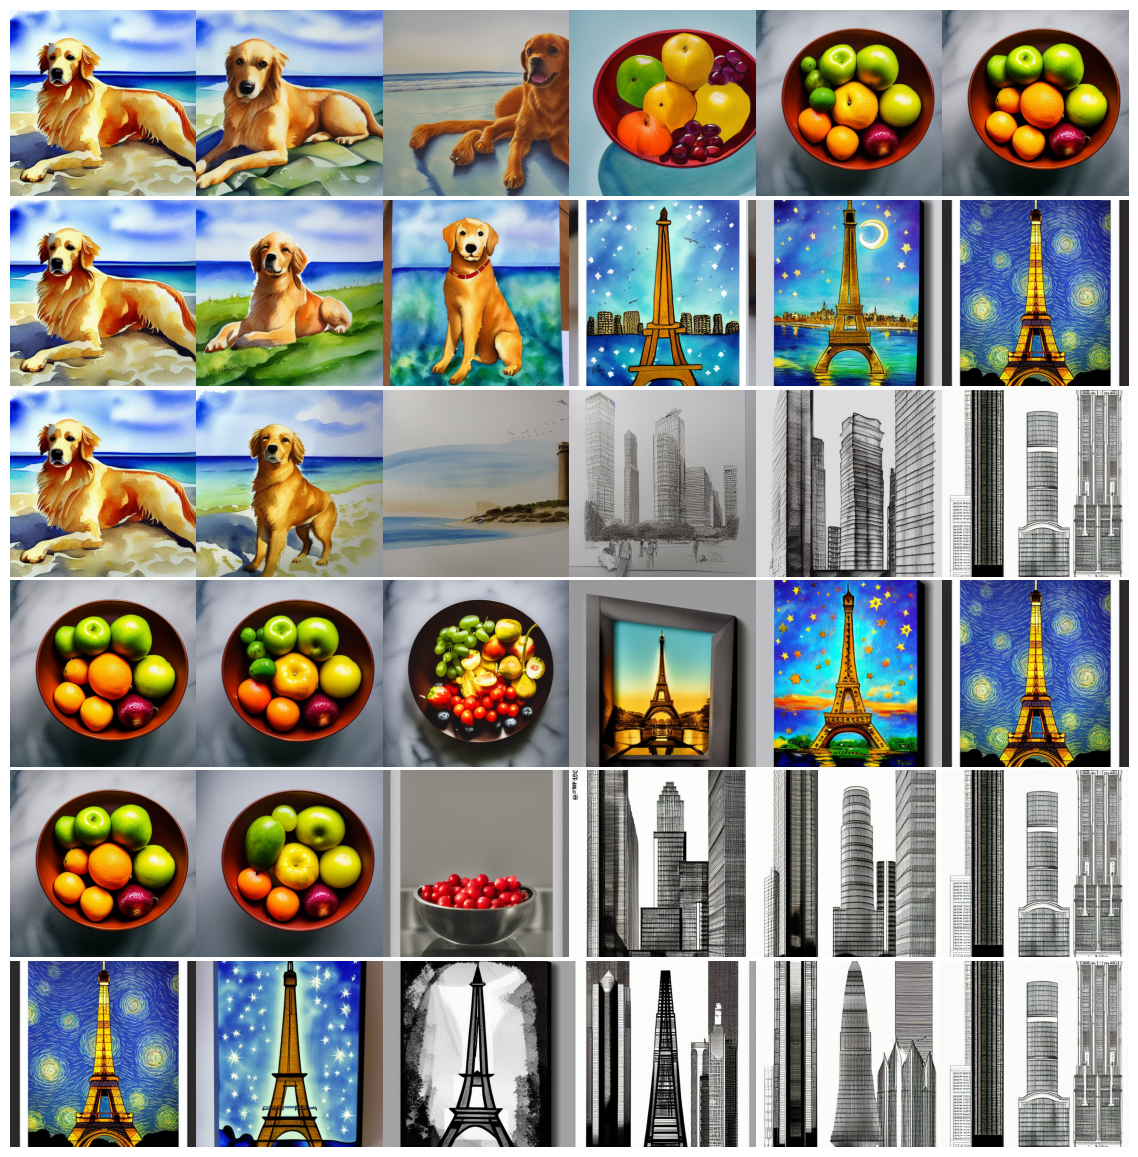

In [18]:
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt

prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
prompt_3 = "The eiffel tower in the style of starry night"
prompt_4 = "An architectural sketch of a skyscraper"

interpolation_steps = 6

# 시드 설정
seed = 42
torch.manual_seed(seed)

# 정규 분포 노이즈 생성
noise = torch.randn(4, 512 // 8, 512 // 8).to(DEVICE)

cond_context_1 = prepare_tokens(prompt_1,models, tokenizer, DEVICE)
cond_context_2 = prepare_tokens(prompt_2, models,tokenizer, DEVICE)
cond_context_3 = prepare_tokens(prompt_3, models,tokenizer, DEVICE)
cond_context_4 = prepare_tokens(prompt_4, models,tokenizer, DEVICE)
uncond_context = prepare_tokens(uncond_prompt,models, tokenizer, DEVICE)


# 인코딩된 텐서들에 대한 선형 보간
interpolation_weights = torch.linspace(0, 1, interpolation_steps, device=DEVICE)

# 모든 조합에 대해 보간
def interpolate_all_combinations(encodings, weights):
    interpolated_encodings = []
    for i in range(len(encodings)):
        for j in range(i + 1, len(encodings)):
            interpolated_encodings += [torch.lerp(encodings[i], encodings[j], weight) for weight in weights]
    return interpolated_encodings

# 모든 조합에 대한 보간 수행
encodings = [cond_context_1, cond_context_2, cond_context_3, cond_context_4]
interpolated_encodings = interpolate_all_combinations(encodings, interpolation_weights)




# 텐서 재구성 및 배치 분할
# interpolated_encodings = torch.stack(interpolated_encodings).view(-1, 77, 768)
# batched_encodings = list(torch.chunk(interpolated_encodings, batches))

images = []
for i in interpolated_encodings:
    
    img_tensor = pipeline.generate(
            prompt_t=i,
            uncond_prompt=uncond_context,
            input_image=input_image,
            latents_cus=noise,
            strength=0.8,
            batch_size=1,
            do_cfg=True,
            art_lab=False,
            latents_custom=True,
            cfg_scale=8,
            sampler_name="ddpm",
            n_inference_steps=50,
            seed=42,
            models=models,
            device=DEVICE,
            idle_device="cpu",
            tokenizer=tokenizer)
    
    img_tensor = img_tensor
    images.append(img_tensor)
    

images = np.concatenate(images)
print(images.shape)
plot_grid(images, "P3.jpg", interpolation_steps)




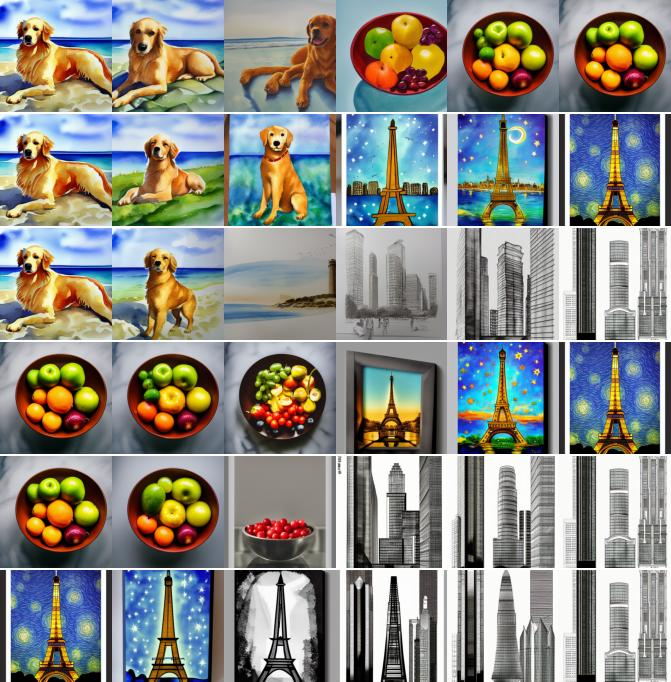

In [24]:
from PIL import Image
from IPython.display import display

# 이미지 파일 경로
file_path = './src/P3.jpg'

# 이미지 열기
image = Image.open(file_path)

# Jupyter 노트북에서 이미지 보여주기
display(image)


---

## 문제 4
네 가지 프롬프트 사이를 보간할 수 있습니다. (w/o noise)

In [ ]:
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt

prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
prompt_3 = "The eiffel tower in the style of starry night"
prompt_4 = "An architectural sketch of a skyscraper"

interpolation_steps = 6



cond_context_1 = prepare_tokens(prompt_1,models, tokenizer, DEVICE)
cond_context_2 = prepare_tokens(prompt_2, models,tokenizer, DEVICE)
cond_context_3 = prepare_tokens(prompt_3, models,tokenizer, DEVICE)
cond_context_4 = prepare_tokens(prompt_4, models,tokenizer, DEVICE)
uncond_context = prepare_tokens(uncond_prompt,models, tokenizer, DEVICE)


# 인코딩된 텐서들에 대한 선형 보간
interpolation_weights = torch.linspace(0, 1, interpolation_steps, device=DEVICE)

# 모든 조합에 대해 보간
def interpolate_all_combinations(encodings, weights):
    interpolated_encodings = []
    for i in range(len(encodings)):
        for j in range(i + 1, len(encodings)):
            interpolated_encodings += [torch.lerp(encodings[i], encodings[j], weight) for weight in weights]
    return interpolated_encodings

# 모든 조합에 대한 보간 수행
encodings = [cond_context_1, cond_context_2, cond_context_3, cond_context_4]
interpolated_encodings = interpolate_all_combinations(encodings, interpolation_weights)




# 텐서 재구성 및 배치 분할
# interpolated_encodings = torch.stack(interpolated_encodings).view(-1, 77, 768)
# batched_encodings = list(torch.chunk(interpolated_encodings, batches))

images = []
for i in interpolated_encodings:
    
    img_tensor = pipeline.generate(
            prompt_t=i,
            uncond_prompt=uncond_context,
            input_image=input_image,
            latents_cus=None,
            strength=0.8,
            batch_size=1,
            do_cfg=True,
            art_lab=False,
            latents_custom=False,
            cfg_scale=8,
            sampler_name="ddpm",
            n_inference_steps=50,
            seed=42,
            models=models,
            device=DEVICE,
            idle_device="cpu",
            tokenizer=tokenizer)
    
    img_tensor = img_tensor
    images.append(img_tensor)


images = np.concatenate(images)
print(images.shape)
plot_grid(images, "P4.jpg", interpolation_steps)




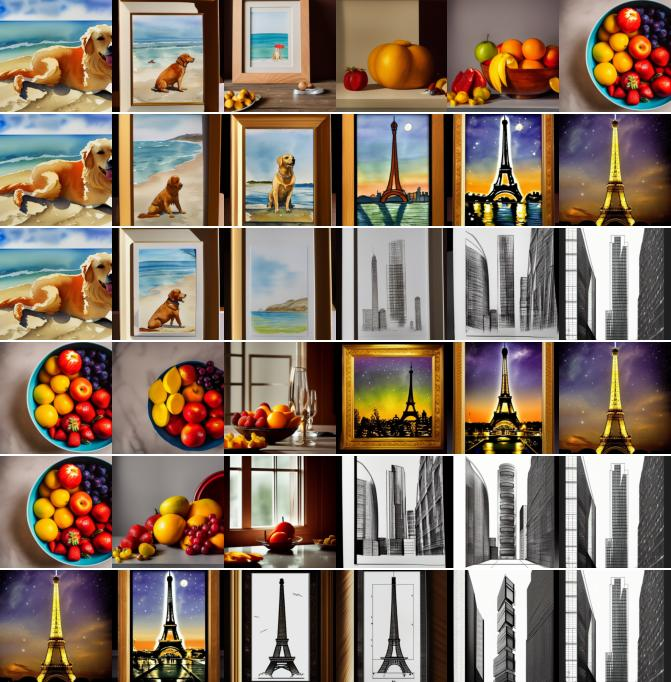

In [25]:
from PIL import Image
from IPython.display import display

# 이미지 파일 경로
file_path = './src/P4.jpg'

# 이미지 열기
image = Image.open(file_path)

# Jupyter 노트북에서 이미지 보여주기
display(image)


---

## 문제 5
- 인코더의 잠재 다양체에서 너무 멀리 떨어져 있으면 일관되지 않은 이미지가 생성되는 것은 당연합니다. 자신만의 프롬프트를 설정하고 step_size걷기의 크기를 늘리거나 줄이도록 조정하여 직접 시도해 보세요. 걷기의 크기가 커지면 걷기는 종종 매우 시끄러운 이미지를 생성하는 영역으로 이어집니다.

In [27]:
walk_steps = 150
step_size = 0.005

prompt_5 = "The Eiffel Tower in the style of starry night"


cond_context_5 = prepare_tokens(prompt_5,models, tokenizer, DEVICE)
uncond_context = prepare_tokens(uncond_prompt,models, tokenizer, DEVICE)
encoding = cond_context_5
delta = torch.ones_like(encoding) * step_size


images = []
for step_index in range(walk_steps):
    encoding += delta
    
    img_tensor = pipeline.generate(
            prompt_t=encoding,
            uncond_prompt=uncond_context,
            input_image=input_image,
            latents_cus=None,
            strength=0.8,
            batch_size=1,
            do_cfg=True,
            art_lab=False,
            latents_custom=False,
            cfg_scale=8,
            sampler_name="ddpm",
            n_inference_steps=50,
            seed=42,
            models=models,
            device=DEVICE,
            idle_device="cpu",
            tokenizer=tokenizer)
    
    img_tensor = img_tensor[0]
    images.append(img_tensor)
    

export_as_gif("P5.gif", [Image.fromarray(img) for img in images], rubber_band=True)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:04<00:00, 12.34it/s]


1


100%|██████████| 50/50 [00:04<00:00, 12.34it/s]


2


100%|██████████| 50/50 [00:04<00:00, 12.31it/s]


3


100%|██████████| 50/50 [00:04<00:00, 12.21it/s]


4


100%|██████████| 50/50 [00:04<00:00, 12.32it/s]


5


100%|██████████| 50/50 [00:04<00:00, 12.32it/s]


6


100%|██████████| 50/50 [00:04<00:00, 12.32it/s]


7


100%|██████████| 50/50 [00:04<00:00, 12.24it/s]


8


100%|██████████| 50/50 [00:04<00:00, 12.31it/s]


9


100%|██████████| 50/50 [00:04<00:00, 12.21it/s]


10


100%|██████████| 50/50 [00:04<00:00, 12.31it/s]


11


100%|██████████| 50/50 [00:04<00:00, 12.33it/s]


12


100%|██████████| 50/50 [00:04<00:00, 12.31it/s]


13


100%|██████████| 50/50 [00:04<00:00, 12.23it/s]


14


100%|██████████| 50/50 [00:04<00:00, 12.32it/s]


15


100%|██████████| 50/50 [00:04<00:00, 12.25it/s]


16


100%|██████████| 50/50 [00:04<00:00, 12.29it/s]


17


 28%|██▊       | 14/50 [00:01<00:02, 12.30it/s]

In [17]:
from PIL import Image, ImageSequence
from IPython.display import display, clear_output
import time

# GIF 파일 경로
file_path = '../src/P5.gif'

# 이미지 열기
img = Image.open(file_path)

# GIF의 각 프레임을 순회하며 시각화
for frame in ImageSequence.Iterator(img):
    # Jupyter 노트북에서 이미지 출력
    clear_output(wait=True)  # 이전 출력을 지웁니다.
    display(frame)  # 현재 프레임을 출력합니다.
    time.sleep(0.1)  # 0.1초 동안 대기합니다.


## 문제 6
## 단일 프롬프트에 대한 확산 노이즈 공간을 통한 원형 이동
 - 우리의 마지막 실험은 하나의 프롬프트를 고수하고 확산 모델이 해당 프롬프트에서 생성할 수 있는 다양한 이미지를 탐색하는 것입니다. 확산 과정을 시드하는 데 사용되는 노이즈를 제어하여 이를 수행합니다. x우리는 두 개의 노이즈 구성 요소 인 과 를 생성 y하고 0에서 2π까지 이동하여 x구성 요소의 코사인과 구성 요소의 죄를 합산하여 y노이즈를 생성합니다. 이 접근 방식을 사용하면 걷기의 끝은 걷기를 시작한 것과 동일한 노이즈 입력에 도달하므로 "루프 가능한" 결과를 얻습니다!

In [ ]:
import torch
import math

latents_shape = (4, 512 // 8, 512 // 8)
generator = torch.Generator(device=DEVICE)
latents = torch.randn(latents_shape, generator=generator, device=DEVICE)

prompt_6 = "An oil paintings of cows in a field next to a windmill in Holland"
cond_context_6 = prepare_tokens(prompt_6,models, tokenizer, DEVICE)
uncond_context = prepare_tokens(uncond_prompt,models, tokenizer, DEVICE)

# tensors = [cond_context_6, cond_context_6, cond_context_6]
# # 텐서들을 새로운 차원에서 결합
# encoding = torch.stack(tensors, dim=0).squeeze(1)
    
# 정규 분포 노이즈 생성
walk_noise_x = torch.randn(latents_shape, dtype=torch.float64)
walk_noise_y = torch.randn(latents_shape, dtype=torch.float64)

walk_steps = 150
# 스케일 계산
walk_scale_x = torch.cos(torch.linspace(0, 2, walk_steps) * math.pi)
walk_scale_y = torch.sin(torch.linspace(0, 2, walk_steps) * math.pi)

walk_scale_x = walk_scale_x.float()  # Float 타입으로 변환
walk_noise_x = walk_noise_x.float()  # Float 타입으로 변환
noise_x = torch.tensordot(walk_scale_x, walk_noise_x, dims=0)

walk_scale_y = walk_scale_y.float()  # Float 타입으로 변환
walk_noise_y = walk_noise_y.float()  # Float 타입으로 변환
noise_y = torch.tensordot(walk_scale_y, walk_noise_y, dims=0)


# 노이즈 결합'
noise = noise_x + noise_y
noise = torch.unbind(noise, dim=0)

images = []
for i in noise:
    i = i.to(DEVICE)
    img_tensor = pipeline.generate(
            prompt_t=cond_context_6,
            uncond_prompt=uncond_context,
            input_image=input_image,
            latents_cus=i,
            strength=0.8,
            batch_size=1,
            do_cfg=True,
            art_lab=False,
            latents_custom=True,
            cfg_scale=8,
            sampler_name="ddpm",
            n_inference_steps=50,
            seed=42,
            models=models,
            device=DEVICE,
            idle_device="cpu",
            tokenizer=tokenizer)
    
    img_tensor = img_tensor[0]
    images.append(img_tensor)
    

export_as_gif("P6.gif", [Image.fromarray(img) for img in images], rubber_band=True)



In [ ]:
from PIL import Image, ImageSequence
from IPython.display import display, clear_output
import time

# GIF 파일 경로
file_path = '../src/P6.gif'

# 이미지 열기
img = Image.open(file_path)

# GIF의 각 프레임을 순회하며 시각화
for frame in ImageSequence.Iterator(img):
    # Jupyter 노트북에서 이미지 출력
    clear_output(wait=True)  # 이전 출력을 지웁니다.
    display(frame)  # 현재 프레임을 출력합니다.
    time.sleep(0.1)  # 0.1초 동안 대기합니다.
